In [19]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV2
from torch_geometric.data import DataLoader 
from model import Net
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [20]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
testpath = "/vols/cms/mm1221/Data/100k/5pi/test/"  
data_test = CCV2(testpath, max_events=1000, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])



### Loading tracksters data


  0%|                                                                                                                                                                                 | 0/1 [01:56<?, ?it/s]

Reached 1000 events!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root'
data_file = uproot.open(data_path)

Track_ind = data_file['tracksters;2']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP;3']['barycenter_x'].array()
energies = data_file['clusters;4']['energy'].array()
LC_x = data_file['clusters;4']['position_x'].array()
LC_y = data_file['clusters;4']['position_y'].array()
LC_z = data_file['clusters;4']['position_z'].array()
LC_eta = data_file['clusters;4']['position_eta'].array()
MT_ind = data_file['trackstersMerged;2']['vertices_indexes'].array()

#1.3 Filter so get rid of events with 0 calo particles
skim_mask = []
for e in GT_bc:
    if 1 <= len(e) <= 5:
        skim_mask.append(True)
    else:
        skim_mask.append(False)

Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
LC_eta = LC_eta[skim_mask]
MT_ind = MT_ind[skim_mask]



In [21]:
# load the model 
model = Net(64, 4, 0.1, 128)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/pion5New/Track/StaticEdge/results/results_lr0.001_bs64_hd64_nl4_do0.1_k8_cd128/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-3): 4 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [23]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [28]:
#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    edge_index = knn_graph(data.x, k=8)  
    predictions = model(data.x, edge_index, 1)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A



In [29]:
import numpy as np
import hdbscan

def HDBSCANClustering(all_predictions, 
                      min_cluster_size=5, 
                      min_samples=None, 
                      metric='euclidean', 
                      alpha=1.0,
                      cluster_selection_method='eom',
                      prediction_data=False,
                      allow_single_cluster=True,
                      core_dist_n_jobs=1,
                      cluster_selection_epsilon=0.0):
    """
    Performs HDBSCAN clustering on a list of prediction arrays with more hyperparameter control.

    Parameters:
    - all_predictions: List of numpy arrays, each containing data points for an event.
    - min_cluster_size: Minimum size of clusters.
    - min_samples: Number of samples in a neighborhood for a point to be considered a core point.
                   If None, it defaults to min_cluster_size.
    - metric: Distance metric to use.
    - alpha: Controls the balance between single linkage and average linkage clustering.
    - cluster_selection_method: 'eom' (Excess of Mass) or 'leaf' for finer clusters.
    - prediction_data: If True, allows later predictions on new data.
    - allow_single_cluster: If True, allows a single large cluster when applicable.
    - core_dist_n_jobs: Number of parallel jobs (-1 uses all cores).
    - cluster_selection_epsilon: Threshold distance for cluster selection (default 0.0).

    Returns:
    - all_cluster_labels: NumPy array of cluster labels for all events.
    """
    all_cluster_labels = []             

    for i, pred in enumerate(all_predictions):
        print(f"Processing event {i+1}/{len(all_predictions)}...")
        
        if len(pred) < 2:
            # Assign all points to cluster 0 (since HDBSCAN uses -1 for noise)
            cluster_labels = np.zeros(len(pred), dtype=int) 
        else:
            # Initialize HDBSCAN with specified parameters
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples if min_samples is not None else min_cluster_size,
                metric=metric,
                alpha=alpha,
                cluster_selection_method=cluster_selection_method,
                prediction_data=prediction_data,
                allow_single_cluster=allow_single_cluster,
                core_dist_n_jobs=core_dist_n_jobs,
                cluster_selection_epsilon=cluster_selection_epsilon
            )
            
            # Perform clustering
            cluster_labels = clusterer.fit_predict(pred)  
        
        all_cluster_labels.append(cluster_labels)
    
    # Convert the list of cluster labels to a NumPy array
    all_cluster_labels = np.array(all_cluster_labels)
    return all_cluster_labels

all_cluster_labels = HDBSCANClustering(
    all_predictions, 
    min_cluster_size=2,  # Ensures at least 3 points per cluster
    metric='euclidean',  # Change distance metric
    alpha=1.0,  # Increase singe linkage weighting
    cluster_selection_method='leaf',  # Allow finer clusters
    prediction_data=False,  # Enable future prediction capability
    allow_single_cluster=False,  # Allow one large cluster
    core_dist_n_jobs=-1  # Use all available CPU cores
)


Processing event 1/9837...
Processing event 2/9837...
Processing event 3/9837...
Processing event 4/9837...
Processing event 5/9837...
Processing event 6/9837...
Processing event 7/9837...
Processing event 8/9837...
Processing event 9/9837...
Processing event 10/9837...
Processing event 11/9837...
Processing event 12/9837...
Processing event 13/9837...
Processing event 14/9837...
Processing event 15/9837...
Processing event 16/9837...
Processing event 17/9837...
Processing event 18/9837...
Processing event 19/9837...
Processing event 20/9837...
Processing event 21/9837...
Processing event 22/9837...
Processing event 23/9837...
Processing event 24/9837...
Processing event 25/9837...
Processing event 26/9837...
Processing event 27/9837...
Processing event 28/9837...
Processing event 29/9837...
Processing event 30/9837...
Processing event 31/9837...
Processing event 32/9837...
Processing event 33/9837...
Processing event 34/9837...
Processing event 35/9837...
Processing event 36/9837...
P

Processing event 316/9837...
Processing event 317/9837...
Processing event 318/9837...
Processing event 319/9837...
Processing event 320/9837...
Processing event 321/9837...
Processing event 322/9837...
Processing event 323/9837...
Processing event 324/9837...
Processing event 325/9837...
Processing event 326/9837...
Processing event 327/9837...
Processing event 328/9837...
Processing event 329/9837...
Processing event 330/9837...
Processing event 331/9837...
Processing event 332/9837...
Processing event 333/9837...
Processing event 334/9837...
Processing event 335/9837...
Processing event 336/9837...
Processing event 337/9837...
Processing event 338/9837...
Processing event 339/9837...
Processing event 340/9837...
Processing event 341/9837...
Processing event 342/9837...
Processing event 343/9837...
Processing event 344/9837...
Processing event 345/9837...
Processing event 346/9837...
Processing event 347/9837...
Processing event 348/9837...
Processing event 349/9837...
Processing eve

Processing event 612/9837...
Processing event 613/9837...
Processing event 614/9837...
Processing event 615/9837...
Processing event 616/9837...
Processing event 617/9837...
Processing event 618/9837...
Processing event 619/9837...
Processing event 620/9837...
Processing event 621/9837...
Processing event 622/9837...
Processing event 623/9837...
Processing event 624/9837...
Processing event 625/9837...
Processing event 626/9837...
Processing event 627/9837...
Processing event 628/9837...
Processing event 629/9837...
Processing event 630/9837...
Processing event 631/9837...
Processing event 632/9837...
Processing event 633/9837...
Processing event 634/9837...
Processing event 635/9837...
Processing event 636/9837...
Processing event 637/9837...
Processing event 638/9837...
Processing event 639/9837...
Processing event 640/9837...
Processing event 641/9837...
Processing event 642/9837...
Processing event 643/9837...
Processing event 644/9837...
Processing event 645/9837...
Processing eve

Processing event 910/9837...
Processing event 911/9837...
Processing event 912/9837...
Processing event 913/9837...
Processing event 914/9837...
Processing event 915/9837...
Processing event 916/9837...
Processing event 917/9837...
Processing event 918/9837...
Processing event 919/9837...
Processing event 920/9837...
Processing event 921/9837...
Processing event 922/9837...
Processing event 923/9837...
Processing event 924/9837...
Processing event 925/9837...
Processing event 926/9837...
Processing event 927/9837...
Processing event 928/9837...
Processing event 929/9837...
Processing event 930/9837...
Processing event 931/9837...
Processing event 932/9837...
Processing event 933/9837...
Processing event 934/9837...
Processing event 935/9837...
Processing event 936/9837...
Processing event 937/9837...
Processing event 938/9837...
Processing event 939/9837...
Processing event 940/9837...
Processing event 941/9837...
Processing event 942/9837...
Processing event 943/9837...
Processing eve

Processing event 1204/9837...
Processing event 1205/9837...
Processing event 1206/9837...
Processing event 1207/9837...
Processing event 1208/9837...
Processing event 1209/9837...
Processing event 1210/9837...
Processing event 1211/9837...
Processing event 1212/9837...
Processing event 1213/9837...
Processing event 1214/9837...
Processing event 1215/9837...
Processing event 1216/9837...
Processing event 1217/9837...
Processing event 1218/9837...
Processing event 1219/9837...
Processing event 1220/9837...
Processing event 1221/9837...
Processing event 1222/9837...
Processing event 1223/9837...
Processing event 1224/9837...
Processing event 1225/9837...
Processing event 1226/9837...
Processing event 1227/9837...
Processing event 1228/9837...
Processing event 1229/9837...
Processing event 1230/9837...
Processing event 1231/9837...
Processing event 1232/9837...
Processing event 1233/9837...
Processing event 1234/9837...
Processing event 1235/9837...
Processing event 1236/9837...
Processing

Processing event 1515/9837...
Processing event 1516/9837...
Processing event 1517/9837...
Processing event 1518/9837...
Processing event 1519/9837...
Processing event 1520/9837...
Processing event 1521/9837...
Processing event 1522/9837...
Processing event 1523/9837...
Processing event 1524/9837...
Processing event 1525/9837...
Processing event 1526/9837...
Processing event 1527/9837...
Processing event 1528/9837...
Processing event 1529/9837...
Processing event 1530/9837...
Processing event 1531/9837...
Processing event 1532/9837...
Processing event 1533/9837...
Processing event 1534/9837...
Processing event 1535/9837...
Processing event 1536/9837...
Processing event 1537/9837...
Processing event 1538/9837...
Processing event 1539/9837...
Processing event 1540/9837...
Processing event 1541/9837...
Processing event 1542/9837...
Processing event 1543/9837...
Processing event 1544/9837...
Processing event 1545/9837...
Processing event 1546/9837...
Processing event 1547/9837...
Processing

Processing event 1813/9837...
Processing event 1814/9837...
Processing event 1815/9837...
Processing event 1816/9837...
Processing event 1817/9837...
Processing event 1818/9837...
Processing event 1819/9837...
Processing event 1820/9837...
Processing event 1821/9837...
Processing event 1822/9837...
Processing event 1823/9837...
Processing event 1824/9837...
Processing event 1825/9837...
Processing event 1826/9837...
Processing event 1827/9837...
Processing event 1828/9837...
Processing event 1829/9837...
Processing event 1830/9837...
Processing event 1831/9837...
Processing event 1832/9837...
Processing event 1833/9837...
Processing event 1834/9837...
Processing event 1835/9837...
Processing event 1836/9837...
Processing event 1837/9837...
Processing event 1838/9837...
Processing event 1839/9837...
Processing event 1840/9837...
Processing event 1841/9837...
Processing event 1842/9837...
Processing event 1843/9837...
Processing event 1844/9837...
Processing event 1845/9837...
Processing

Processing event 2128/9837...
Processing event 2129/9837...
Processing event 2130/9837...
Processing event 2131/9837...
Processing event 2132/9837...
Processing event 2133/9837...
Processing event 2134/9837...
Processing event 2135/9837...
Processing event 2136/9837...
Processing event 2137/9837...
Processing event 2138/9837...
Processing event 2139/9837...
Processing event 2140/9837...
Processing event 2141/9837...
Processing event 2142/9837...
Processing event 2143/9837...
Processing event 2144/9837...
Processing event 2145/9837...
Processing event 2146/9837...
Processing event 2147/9837...
Processing event 2148/9837...
Processing event 2149/9837...
Processing event 2150/9837...
Processing event 2151/9837...
Processing event 2152/9837...
Processing event 2153/9837...
Processing event 2154/9837...
Processing event 2155/9837...
Processing event 2156/9837...
Processing event 2157/9837...
Processing event 2158/9837...
Processing event 2159/9837...
Processing event 2160/9837...
Processing

Processing event 2419/9837...
Processing event 2420/9837...
Processing event 2421/9837...
Processing event 2422/9837...
Processing event 2423/9837...
Processing event 2424/9837...
Processing event 2425/9837...
Processing event 2426/9837...
Processing event 2427/9837...
Processing event 2428/9837...
Processing event 2429/9837...
Processing event 2430/9837...
Processing event 2431/9837...
Processing event 2432/9837...
Processing event 2433/9837...
Processing event 2434/9837...
Processing event 2435/9837...
Processing event 2436/9837...
Processing event 2437/9837...
Processing event 2438/9837...
Processing event 2439/9837...
Processing event 2440/9837...
Processing event 2441/9837...
Processing event 2442/9837...
Processing event 2443/9837...
Processing event 2444/9837...
Processing event 2445/9837...
Processing event 2446/9837...
Processing event 2447/9837...
Processing event 2448/9837...
Processing event 2449/9837...
Processing event 2450/9837...
Processing event 2451/9837...
Processing

Processing event 2720/9837...
Processing event 2721/9837...
Processing event 2722/9837...
Processing event 2723/9837...
Processing event 2724/9837...
Processing event 2725/9837...
Processing event 2726/9837...
Processing event 2727/9837...
Processing event 2728/9837...
Processing event 2729/9837...
Processing event 2730/9837...
Processing event 2731/9837...
Processing event 2732/9837...
Processing event 2733/9837...
Processing event 2734/9837...
Processing event 2735/9837...
Processing event 2736/9837...
Processing event 2737/9837...
Processing event 2738/9837...
Processing event 2739/9837...
Processing event 2740/9837...
Processing event 2741/9837...
Processing event 2742/9837...
Processing event 2743/9837...
Processing event 2744/9837...
Processing event 2745/9837...
Processing event 2746/9837...
Processing event 2747/9837...
Processing event 2748/9837...
Processing event 2749/9837...
Processing event 2750/9837...
Processing event 2751/9837...
Processing event 2752/9837...
Processing

Processing event 3034/9837...
Processing event 3035/9837...
Processing event 3036/9837...
Processing event 3037/9837...
Processing event 3038/9837...
Processing event 3039/9837...
Processing event 3040/9837...
Processing event 3041/9837...
Processing event 3042/9837...
Processing event 3043/9837...
Processing event 3044/9837...
Processing event 3045/9837...
Processing event 3046/9837...
Processing event 3047/9837...
Processing event 3048/9837...
Processing event 3049/9837...
Processing event 3050/9837...
Processing event 3051/9837...
Processing event 3052/9837...
Processing event 3053/9837...
Processing event 3054/9837...
Processing event 3055/9837...
Processing event 3056/9837...
Processing event 3057/9837...
Processing event 3058/9837...
Processing event 3059/9837...
Processing event 3060/9837...
Processing event 3061/9837...
Processing event 3062/9837...
Processing event 3063/9837...
Processing event 3064/9837...
Processing event 3065/9837...
Processing event 3066/9837...
Processing

Processing event 3336/9837...
Processing event 3337/9837...
Processing event 3338/9837...
Processing event 3339/9837...
Processing event 3340/9837...
Processing event 3341/9837...
Processing event 3342/9837...
Processing event 3343/9837...
Processing event 3344/9837...
Processing event 3345/9837...
Processing event 3346/9837...
Processing event 3347/9837...
Processing event 3348/9837...
Processing event 3349/9837...
Processing event 3350/9837...
Processing event 3351/9837...
Processing event 3352/9837...
Processing event 3353/9837...
Processing event 3354/9837...
Processing event 3355/9837...
Processing event 3356/9837...
Processing event 3357/9837...
Processing event 3358/9837...
Processing event 3359/9837...
Processing event 3360/9837...
Processing event 3361/9837...
Processing event 3362/9837...
Processing event 3363/9837...
Processing event 3364/9837...
Processing event 3365/9837...
Processing event 3366/9837...
Processing event 3367/9837...
Processing event 3368/9837...
Processing

Processing event 3646/9837...
Processing event 3647/9837...
Processing event 3648/9837...
Processing event 3649/9837...
Processing event 3650/9837...
Processing event 3651/9837...
Processing event 3652/9837...
Processing event 3653/9837...
Processing event 3654/9837...
Processing event 3655/9837...
Processing event 3656/9837...
Processing event 3657/9837...
Processing event 3658/9837...
Processing event 3659/9837...
Processing event 3660/9837...
Processing event 3661/9837...
Processing event 3662/9837...
Processing event 3663/9837...
Processing event 3664/9837...
Processing event 3665/9837...
Processing event 3666/9837...
Processing event 3667/9837...
Processing event 3668/9837...
Processing event 3669/9837...
Processing event 3670/9837...
Processing event 3671/9837...
Processing event 3672/9837...
Processing event 3673/9837...
Processing event 3674/9837...
Processing event 3675/9837...
Processing event 3676/9837...
Processing event 3677/9837...
Processing event 3678/9837...
Processing

Processing event 3948/9837...
Processing event 3949/9837...
Processing event 3950/9837...
Processing event 3951/9837...
Processing event 3952/9837...
Processing event 3953/9837...
Processing event 3954/9837...
Processing event 3955/9837...
Processing event 3956/9837...
Processing event 3957/9837...
Processing event 3958/9837...
Processing event 3959/9837...
Processing event 3960/9837...
Processing event 3961/9837...
Processing event 3962/9837...
Processing event 3963/9837...
Processing event 3964/9837...
Processing event 3965/9837...
Processing event 3966/9837...
Processing event 3967/9837...
Processing event 3968/9837...
Processing event 3969/9837...
Processing event 3970/9837...
Processing event 3971/9837...
Processing event 3972/9837...
Processing event 3973/9837...
Processing event 3974/9837...
Processing event 3975/9837...
Processing event 3976/9837...
Processing event 3977/9837...
Processing event 3978/9837...
Processing event 3979/9837...
Processing event 3980/9837...
Processing

Processing event 4245/9837...
Processing event 4246/9837...
Processing event 4247/9837...
Processing event 4248/9837...
Processing event 4249/9837...
Processing event 4250/9837...
Processing event 4251/9837...
Processing event 4252/9837...
Processing event 4253/9837...
Processing event 4254/9837...
Processing event 4255/9837...
Processing event 4256/9837...
Processing event 4257/9837...
Processing event 4258/9837...
Processing event 4259/9837...
Processing event 4260/9837...
Processing event 4261/9837...
Processing event 4262/9837...
Processing event 4263/9837...
Processing event 4264/9837...
Processing event 4265/9837...
Processing event 4266/9837...
Processing event 4267/9837...
Processing event 4268/9837...
Processing event 4269/9837...
Processing event 4270/9837...
Processing event 4271/9837...
Processing event 4272/9837...
Processing event 4273/9837...
Processing event 4274/9837...
Processing event 4275/9837...
Processing event 4276/9837...
Processing event 4277/9837...
Processing

Processing event 4549/9837...
Processing event 4550/9837...
Processing event 4551/9837...
Processing event 4552/9837...
Processing event 4553/9837...
Processing event 4554/9837...
Processing event 4555/9837...
Processing event 4556/9837...
Processing event 4557/9837...
Processing event 4558/9837...
Processing event 4559/9837...
Processing event 4560/9837...
Processing event 4561/9837...
Processing event 4562/9837...
Processing event 4563/9837...
Processing event 4564/9837...
Processing event 4565/9837...
Processing event 4566/9837...
Processing event 4567/9837...
Processing event 4568/9837...
Processing event 4569/9837...
Processing event 4570/9837...
Processing event 4571/9837...
Processing event 4572/9837...
Processing event 4573/9837...
Processing event 4574/9837...
Processing event 4575/9837...
Processing event 4576/9837...
Processing event 4577/9837...
Processing event 4578/9837...
Processing event 4579/9837...
Processing event 4580/9837...
Processing event 4581/9837...
Processing

Processing event 4856/9837...
Processing event 4857/9837...
Processing event 4858/9837...
Processing event 4859/9837...
Processing event 4860/9837...
Processing event 4861/9837...
Processing event 4862/9837...
Processing event 4863/9837...
Processing event 4864/9837...
Processing event 4865/9837...
Processing event 4866/9837...
Processing event 4867/9837...
Processing event 4868/9837...
Processing event 4869/9837...
Processing event 4870/9837...
Processing event 4871/9837...
Processing event 4872/9837...
Processing event 4873/9837...
Processing event 4874/9837...
Processing event 4875/9837...
Processing event 4876/9837...
Processing event 4877/9837...
Processing event 4878/9837...
Processing event 4879/9837...
Processing event 4880/9837...
Processing event 4881/9837...
Processing event 4882/9837...
Processing event 4883/9837...
Processing event 4884/9837...
Processing event 4885/9837...
Processing event 4886/9837...
Processing event 4887/9837...
Processing event 4888/9837...
Processing

Processing event 5167/9837...
Processing event 5168/9837...
Processing event 5169/9837...
Processing event 5170/9837...
Processing event 5171/9837...
Processing event 5172/9837...
Processing event 5173/9837...
Processing event 5174/9837...
Processing event 5175/9837...
Processing event 5176/9837...
Processing event 5177/9837...
Processing event 5178/9837...
Processing event 5179/9837...
Processing event 5180/9837...
Processing event 5181/9837...
Processing event 5182/9837...
Processing event 5183/9837...
Processing event 5184/9837...
Processing event 5185/9837...
Processing event 5186/9837...
Processing event 5187/9837...
Processing event 5188/9837...
Processing event 5189/9837...
Processing event 5190/9837...
Processing event 5191/9837...
Processing event 5192/9837...
Processing event 5193/9837...
Processing event 5194/9837...
Processing event 5195/9837...
Processing event 5196/9837...
Processing event 5197/9837...
Processing event 5198/9837...
Processing event 5199/9837...
Processing

Processing event 5462/9837...
Processing event 5463/9837...
Processing event 5464/9837...
Processing event 5465/9837...
Processing event 5466/9837...
Processing event 5467/9837...
Processing event 5468/9837...
Processing event 5469/9837...
Processing event 5470/9837...
Processing event 5471/9837...
Processing event 5472/9837...
Processing event 5473/9837...
Processing event 5474/9837...
Processing event 5475/9837...
Processing event 5476/9837...
Processing event 5477/9837...
Processing event 5478/9837...
Processing event 5479/9837...
Processing event 5480/9837...
Processing event 5481/9837...
Processing event 5482/9837...
Processing event 5483/9837...
Processing event 5484/9837...
Processing event 5485/9837...
Processing event 5486/9837...
Processing event 5487/9837...
Processing event 5488/9837...
Processing event 5489/9837...
Processing event 5490/9837...
Processing event 5491/9837...
Processing event 5492/9837...
Processing event 5493/9837...
Processing event 5494/9837...
Processing

Processing event 5770/9837...
Processing event 5771/9837...
Processing event 5772/9837...
Processing event 5773/9837...
Processing event 5774/9837...
Processing event 5775/9837...
Processing event 5776/9837...
Processing event 5777/9837...
Processing event 5778/9837...
Processing event 5779/9837...
Processing event 5780/9837...
Processing event 5781/9837...
Processing event 5782/9837...
Processing event 5783/9837...
Processing event 5784/9837...
Processing event 5785/9837...
Processing event 5786/9837...
Processing event 5787/9837...
Processing event 5788/9837...
Processing event 5789/9837...
Processing event 5790/9837...
Processing event 5791/9837...
Processing event 5792/9837...
Processing event 5793/9837...
Processing event 5794/9837...
Processing event 5795/9837...
Processing event 5796/9837...
Processing event 5797/9837...
Processing event 5798/9837...
Processing event 5799/9837...
Processing event 5800/9837...
Processing event 5801/9837...
Processing event 5802/9837...
Processing

Processing event 6066/9837...
Processing event 6067/9837...
Processing event 6068/9837...
Processing event 6069/9837...
Processing event 6070/9837...
Processing event 6071/9837...
Processing event 6072/9837...
Processing event 6073/9837...
Processing event 6074/9837...
Processing event 6075/9837...
Processing event 6076/9837...
Processing event 6077/9837...
Processing event 6078/9837...
Processing event 6079/9837...
Processing event 6080/9837...
Processing event 6081/9837...
Processing event 6082/9837...
Processing event 6083/9837...
Processing event 6084/9837...
Processing event 6085/9837...
Processing event 6086/9837...
Processing event 6087/9837...
Processing event 6088/9837...
Processing event 6089/9837...
Processing event 6090/9837...
Processing event 6091/9837...
Processing event 6092/9837...
Processing event 6093/9837...
Processing event 6094/9837...
Processing event 6095/9837...
Processing event 6096/9837...
Processing event 6097/9837...
Processing event 6098/9837...
Processing

Processing event 6371/9837...
Processing event 6372/9837...
Processing event 6373/9837...
Processing event 6374/9837...
Processing event 6375/9837...
Processing event 6376/9837...
Processing event 6377/9837...
Processing event 6378/9837...
Processing event 6379/9837...
Processing event 6380/9837...
Processing event 6381/9837...
Processing event 6382/9837...
Processing event 6383/9837...
Processing event 6384/9837...
Processing event 6385/9837...
Processing event 6386/9837...
Processing event 6387/9837...
Processing event 6388/9837...
Processing event 6389/9837...
Processing event 6390/9837...
Processing event 6391/9837...
Processing event 6392/9837...
Processing event 6393/9837...
Processing event 6394/9837...
Processing event 6395/9837...
Processing event 6396/9837...
Processing event 6397/9837...
Processing event 6398/9837...
Processing event 6399/9837...
Processing event 6400/9837...
Processing event 6401/9837...
Processing event 6402/9837...
Processing event 6403/9837...
Processing

Processing event 6686/9837...
Processing event 6687/9837...
Processing event 6688/9837...
Processing event 6689/9837...
Processing event 6690/9837...
Processing event 6691/9837...
Processing event 6692/9837...
Processing event 6693/9837...
Processing event 6694/9837...
Processing event 6695/9837...
Processing event 6696/9837...
Processing event 6697/9837...
Processing event 6698/9837...
Processing event 6699/9837...
Processing event 6700/9837...
Processing event 6701/9837...
Processing event 6702/9837...
Processing event 6703/9837...
Processing event 6704/9837...
Processing event 6705/9837...
Processing event 6706/9837...
Processing event 6707/9837...
Processing event 6708/9837...
Processing event 6709/9837...
Processing event 6710/9837...
Processing event 6711/9837...
Processing event 6712/9837...
Processing event 6713/9837...
Processing event 6714/9837...
Processing event 6715/9837...
Processing event 6716/9837...
Processing event 6717/9837...
Processing event 6718/9837...
Processing

Processing event 6991/9837...
Processing event 6992/9837...
Processing event 6993/9837...
Processing event 6994/9837...
Processing event 6995/9837...
Processing event 6996/9837...
Processing event 6997/9837...
Processing event 6998/9837...
Processing event 6999/9837...
Processing event 7000/9837...
Processing event 7001/9837...
Processing event 7002/9837...
Processing event 7003/9837...
Processing event 7004/9837...
Processing event 7005/9837...
Processing event 7006/9837...
Processing event 7007/9837...
Processing event 7008/9837...
Processing event 7009/9837...
Processing event 7010/9837...
Processing event 7011/9837...
Processing event 7012/9837...
Processing event 7013/9837...
Processing event 7014/9837...
Processing event 7015/9837...
Processing event 7016/9837...
Processing event 7017/9837...
Processing event 7018/9837...
Processing event 7019/9837...
Processing event 7020/9837...
Processing event 7021/9837...
Processing event 7022/9837...
Processing event 7023/9837...
Processing

Processing event 7289/9837...
Processing event 7290/9837...
Processing event 7291/9837...
Processing event 7292/9837...
Processing event 7293/9837...
Processing event 7294/9837...
Processing event 7295/9837...
Processing event 7296/9837...
Processing event 7297/9837...
Processing event 7298/9837...
Processing event 7299/9837...
Processing event 7300/9837...
Processing event 7301/9837...
Processing event 7302/9837...
Processing event 7303/9837...
Processing event 7304/9837...
Processing event 7305/9837...
Processing event 7306/9837...
Processing event 7307/9837...
Processing event 7308/9837...
Processing event 7309/9837...
Processing event 7310/9837...
Processing event 7311/9837...
Processing event 7312/9837...
Processing event 7313/9837...
Processing event 7314/9837...
Processing event 7315/9837...
Processing event 7316/9837...
Processing event 7317/9837...
Processing event 7318/9837...
Processing event 7319/9837...
Processing event 7320/9837...
Processing event 7321/9837...
Processing

Processing event 7578/9837...
Processing event 7579/9837...
Processing event 7580/9837...
Processing event 7581/9837...
Processing event 7582/9837...
Processing event 7583/9837...
Processing event 7584/9837...
Processing event 7585/9837...
Processing event 7586/9837...
Processing event 7587/9837...
Processing event 7588/9837...
Processing event 7589/9837...
Processing event 7590/9837...
Processing event 7591/9837...
Processing event 7592/9837...
Processing event 7593/9837...
Processing event 7594/9837...
Processing event 7595/9837...
Processing event 7596/9837...
Processing event 7597/9837...
Processing event 7598/9837...
Processing event 7599/9837...
Processing event 7600/9837...
Processing event 7601/9837...
Processing event 7602/9837...
Processing event 7603/9837...
Processing event 7604/9837...
Processing event 7605/9837...
Processing event 7606/9837...
Processing event 7607/9837...
Processing event 7608/9837...
Processing event 7609/9837...
Processing event 7610/9837...
Processing

Processing event 7883/9837...
Processing event 7884/9837...
Processing event 7885/9837...
Processing event 7886/9837...
Processing event 7887/9837...
Processing event 7888/9837...
Processing event 7889/9837...
Processing event 7890/9837...
Processing event 7891/9837...
Processing event 7892/9837...
Processing event 7893/9837...
Processing event 7894/9837...
Processing event 7895/9837...
Processing event 7896/9837...
Processing event 7897/9837...
Processing event 7898/9837...
Processing event 7899/9837...
Processing event 7900/9837...
Processing event 7901/9837...
Processing event 7902/9837...
Processing event 7903/9837...
Processing event 7904/9837...
Processing event 7905/9837...
Processing event 7906/9837...
Processing event 7907/9837...
Processing event 7908/9837...
Processing event 7909/9837...
Processing event 7910/9837...
Processing event 7911/9837...
Processing event 7912/9837...
Processing event 7913/9837...
Processing event 7914/9837...
Processing event 7915/9837...
Processing

Processing event 8189/9837...
Processing event 8190/9837...
Processing event 8191/9837...
Processing event 8192/9837...
Processing event 8193/9837...
Processing event 8194/9837...
Processing event 8195/9837...
Processing event 8196/9837...
Processing event 8197/9837...
Processing event 8198/9837...
Processing event 8199/9837...
Processing event 8200/9837...
Processing event 8201/9837...
Processing event 8202/9837...
Processing event 8203/9837...
Processing event 8204/9837...
Processing event 8205/9837...
Processing event 8206/9837...
Processing event 8207/9837...
Processing event 8208/9837...
Processing event 8209/9837...
Processing event 8210/9837...
Processing event 8211/9837...
Processing event 8212/9837...
Processing event 8213/9837...
Processing event 8214/9837...
Processing event 8215/9837...
Processing event 8216/9837...
Processing event 8217/9837...
Processing event 8218/9837...
Processing event 8219/9837...
Processing event 8220/9837...
Processing event 8221/9837...
Processing

Processing event 8485/9837...
Processing event 8486/9837...
Processing event 8487/9837...
Processing event 8488/9837...
Processing event 8489/9837...
Processing event 8490/9837...
Processing event 8491/9837...
Processing event 8492/9837...
Processing event 8493/9837...
Processing event 8494/9837...
Processing event 8495/9837...
Processing event 8496/9837...
Processing event 8497/9837...
Processing event 8498/9837...
Processing event 8499/9837...
Processing event 8500/9837...
Processing event 8501/9837...
Processing event 8502/9837...
Processing event 8503/9837...
Processing event 8504/9837...
Processing event 8505/9837...
Processing event 8506/9837...
Processing event 8507/9837...
Processing event 8508/9837...
Processing event 8509/9837...
Processing event 8510/9837...
Processing event 8511/9837...
Processing event 8512/9837...
Processing event 8513/9837...
Processing event 8514/9837...
Processing event 8515/9837...
Processing event 8516/9837...
Processing event 8517/9837...
Processing

Processing event 8778/9837...
Processing event 8779/9837...
Processing event 8780/9837...
Processing event 8781/9837...
Processing event 8782/9837...
Processing event 8783/9837...
Processing event 8784/9837...
Processing event 8785/9837...
Processing event 8786/9837...
Processing event 8787/9837...
Processing event 8788/9837...
Processing event 8789/9837...
Processing event 8790/9837...
Processing event 8791/9837...
Processing event 8792/9837...
Processing event 8793/9837...
Processing event 8794/9837...
Processing event 8795/9837...
Processing event 8796/9837...
Processing event 8797/9837...
Processing event 8798/9837...
Processing event 8799/9837...
Processing event 8800/9837...
Processing event 8801/9837...
Processing event 8802/9837...
Processing event 8803/9837...
Processing event 8804/9837...
Processing event 8805/9837...
Processing event 8806/9837...
Processing event 8807/9837...
Processing event 8808/9837...
Processing event 8809/9837...
Processing event 8810/9837...
Processing

Processing event 9076/9837...
Processing event 9077/9837...
Processing event 9078/9837...
Processing event 9079/9837...
Processing event 9080/9837...
Processing event 9081/9837...
Processing event 9082/9837...
Processing event 9083/9837...
Processing event 9084/9837...
Processing event 9085/9837...
Processing event 9086/9837...
Processing event 9087/9837...
Processing event 9088/9837...
Processing event 9089/9837...
Processing event 9090/9837...
Processing event 9091/9837...
Processing event 9092/9837...
Processing event 9093/9837...
Processing event 9094/9837...
Processing event 9095/9837...
Processing event 9096/9837...
Processing event 9097/9837...
Processing event 9098/9837...
Processing event 9099/9837...
Processing event 9100/9837...
Processing event 9101/9837...
Processing event 9102/9837...
Processing event 9103/9837...
Processing event 9104/9837...
Processing event 9105/9837...
Processing event 9106/9837...
Processing event 9107/9837...
Processing event 9108/9837...
Processing

Processing event 9382/9837...
Processing event 9383/9837...
Processing event 9384/9837...
Processing event 9385/9837...
Processing event 9386/9837...
Processing event 9387/9837...
Processing event 9388/9837...
Processing event 9389/9837...
Processing event 9390/9837...
Processing event 9391/9837...
Processing event 9392/9837...
Processing event 9393/9837...
Processing event 9394/9837...
Processing event 9395/9837...
Processing event 9396/9837...
Processing event 9397/9837...
Processing event 9398/9837...
Processing event 9399/9837...
Processing event 9400/9837...
Processing event 9401/9837...
Processing event 9402/9837...
Processing event 9403/9837...
Processing event 9404/9837...
Processing event 9405/9837...
Processing event 9406/9837...
Processing event 9407/9837...
Processing event 9408/9837...
Processing event 9409/9837...
Processing event 9410/9837...
Processing event 9411/9837...
Processing event 9412/9837...
Processing event 9413/9837...
Processing event 9414/9837...
Processing

Processing event 9685/9837...
Processing event 9686/9837...
Processing event 9687/9837...
Processing event 9688/9837...
Processing event 9689/9837...
Processing event 9690/9837...
Processing event 9691/9837...
Processing event 9692/9837...
Processing event 9693/9837...
Processing event 9694/9837...
Processing event 9695/9837...
Processing event 9696/9837...
Processing event 9697/9837...
Processing event 9698/9837...
Processing event 9699/9837...
Processing event 9700/9837...
Processing event 9701/9837...
Processing event 9702/9837...
Processing event 9703/9837...
Processing event 9704/9837...
Processing event 9705/9837...
Processing event 9706/9837...
Processing event 9707/9837...
Processing event 9708/9837...
Processing event 9709/9837...
Processing event 9710/9837...
Processing event 9711/9837...
Processing event 9712/9837...
Processing event 9713/9837...
Processing event 9714/9837...
Processing event 9715/9837...
Processing event 9716/9837...
Processing event 9717/9837...
Processing

In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar
def calculate_all_event_scores2(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, multi, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in range(num_events):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_multi = multi[event_index]

        # Extract layer cluster positions and eta for this event
        event_x = np.array(LC_x[event_index])
        event_y = np.array(LC_y[event_index])
        event_z = np.array(LC_z[event_index])
        event_eta = np.array(LC_eta[event_index])

        # Compute barycenter for each CaloParticle
        cp_barycenters = []
        cp_avg_etas = []
        for caloparticle in caloparticles:
            # Compute barycenter (x, y, z)
            
            barycenter_x = np.mean([event_x[det_id] for det_id in caloparticle])
            barycenter_y = np.mean([event_y[det_id] for det_id in caloparticle])
            barycenter_z = np.mean([event_z[det_id] for det_id in caloparticle])
            cp_barycenters.append(np.array([barycenter_x, barycenter_y, barycenter_z]))
            
            # Compute average eta
            avg_eta = np.mean([event_eta[det_id] for det_id in caloparticle])
            cp_avg_etas.append(avg_eta)

        # Compute separation between two CaloParticles if at least two exist
        if len(cp_barycenters) >= 2:
            cp_separation = np.linalg.norm(cp_barycenters[0] - cp_barycenters[1])
        else:
            cp_separation = 0.0
            
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]

        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                
                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                
                
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, Calo_multi)
                # Calculate reco-to-sim score
                reco_to_sim_score = calculate_reco_to_sim_score(trackster, event_energies, caloparticle, Calo_multi)

                # Calculate total energy for CaloParticle and Trackster
                cp_energy_lc2 = event_energies[caloparticle] / Calo_multi
                cp_energy = np.sum(cp_energy_lc2)
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "cp_avg_eta": cp_avg_etas[calo_idx],
                    "cp_separation": cp_separation,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [31]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN


In [32]:
df_CL = calculate_all_event_scores2(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)
#df_TICL = calculate_all_event_scores2(GT_ind, energies, MT_ind_filt, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)

In [33]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to process each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Average Energy Ratio Calculation -----
    low_score_mask = df['sim_to_reco_score'] < 0.2
    low_score_events = df[low_score_mask]
    if not low_score_events.empty:
        avg_energy_ratio = (low_score_events['trackster_energy'] / low_score_events['cp_energy']).mean()
    else:
        avg_energy_ratio = 0

    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")
    print(f"Average Energy Ratio: {avg_energy_ratio:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'avg_energy_ratio': avg_energy_ratio,
    }

# Example usage
our_model_metrics = calculate_metrics(df_CL, "Our Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")


Model: Our Model
Efficiency: 0.7445 (2142 associated CPs out of 2877 total CPs)
Purity: 0.9109 (2944 associated Tracksters out of 3232 total Tracksters)
Num tracksters ratio: 1.1234
Average Energy Ratio: 1.1979

Model: CERN Model
Efficiency: 0.7258 (2086 associated CPs out of 2874 total CPs)
Purity: 0.9966 (5214 associated Tracksters out of 5232 total Tracksters)
Num tracksters ratio: 1.8205
Average Energy Ratio: 0.7081


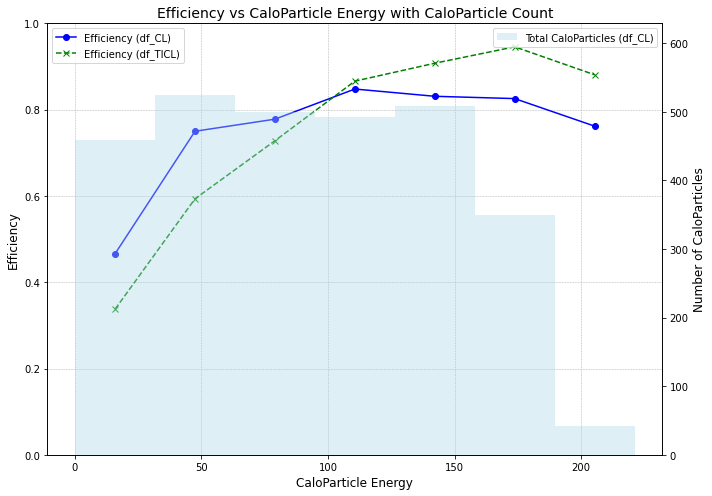

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_CL and df_TICL are your two DataFrames
# Replace the following with your actual data loading mechanism
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')

# ----- Preprocessing -----
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')  # New Column
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy (they are identical).
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',          
        'shared_energy': 'max'        # Use max to determine if any shared_energy meets the threshold
    }).reset_index()
    
    # Mark as reconstructed if any shared_energy >= 50% of cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp = prepare_cp_data(df_TICL)

# ----- Bin Caloparticles by Energy -----
# Define energy bins based on the range of cp_energy from df_CL.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = df_CL_cp['cp_energy'].max()
n_bins = 7
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ----- Calculate Efficiency per Energy Bin -----
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)

# ----- Plot Efficiency vs Energy with Histogram Overlay -----
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

# Create a figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()

# Plot Efficiency
ax1.plot(bin_centers, agg_CL['efficiency'], marker='o', linestyle='-', color='blue', label='Efficiency (df_CL)')
ax1.plot(bin_centers, agg_TICL['efficiency'],   marker='x', linestyle='--', color='green', label='Efficiency (df_TICL)')
ax1.set_xlabel('CaloParticle Energy', fontsize=12)
ax1.set_ylabel('Efficiency', fontsize=12)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Number of Caloparticles as Histogram
ax2.bar(bin_centers, agg_CL['total_cp'], width=bar_width, 
        color='lightblue', alpha=0.4, label='Total CaloParticles (df_CL)')
ax2.set_ylim(0, agg_CL['total_cp'].max() * 1.2)
ax2.set_ylabel('Number of CaloParticles', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

# Update Title to Reflect New Efficiency Definition
plt.title('Efficiency vs CaloParticle Energy with CaloParticle Count', fontsize=14)
plt.tight_layout()
plt.show()


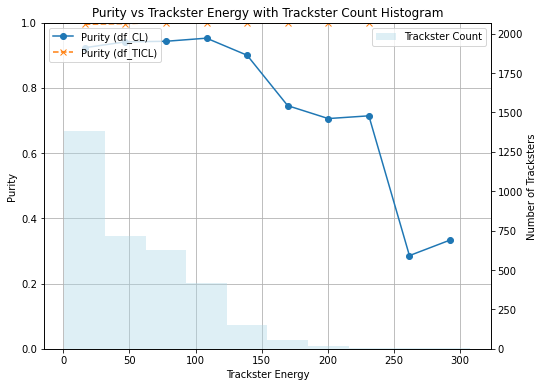

In [17]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = df_CL_ts['trackster_energy'].max()
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

# Create a figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Plot purity curves on the primary y-axis.
ax1.plot(bin_centers_ts, agg_CL_ts['purity'], marker='o', linestyle='-', label='Purity (df_CL)')
ax1.plot(bin_centers_ts, agg_TICL_ts['purity'], marker='x', linestyle='--', label='Purity (df_TICL)')
ax1.set_xlabel('Trackster Energy')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax2.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts,
        color='lightblue', alpha=0.4, label='Trackster Count')
ax2.set_ylabel('Number of Tracksters')
ax2.set_ylim(0, (agg_CL_ts['total_ts'].max() or 1) * 1.5)
ax2.legend(loc='upper right')

plt.title('Purity vs Trackster Energy with Trackster Count Histogram')
plt.show()

# Response and Resolution

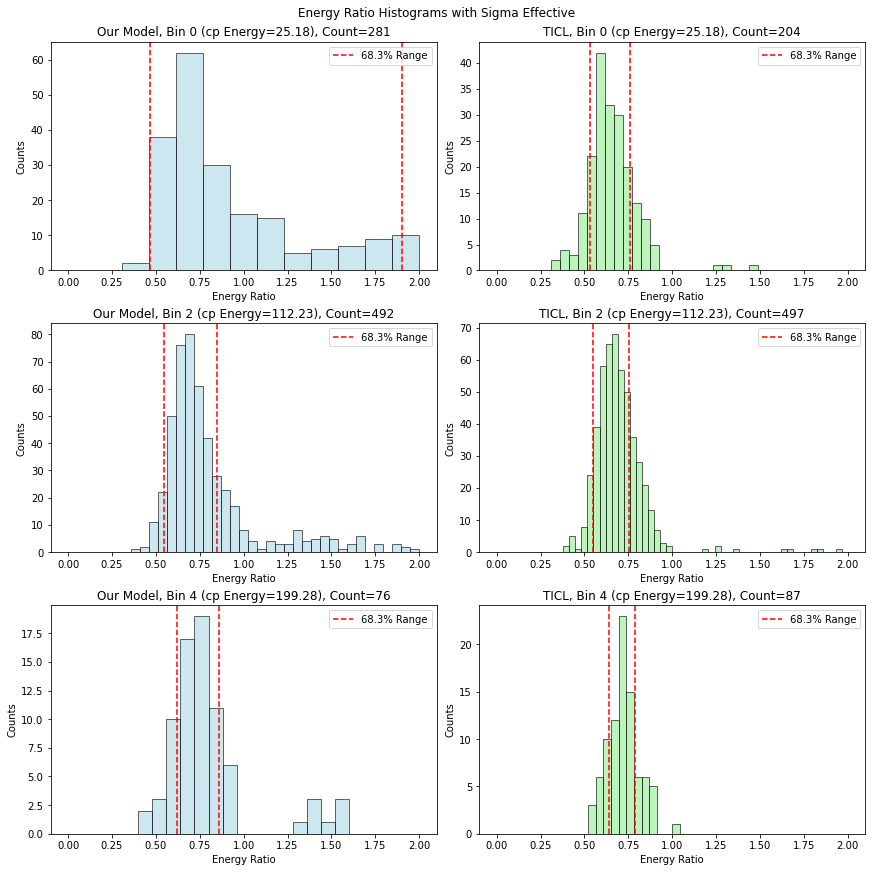

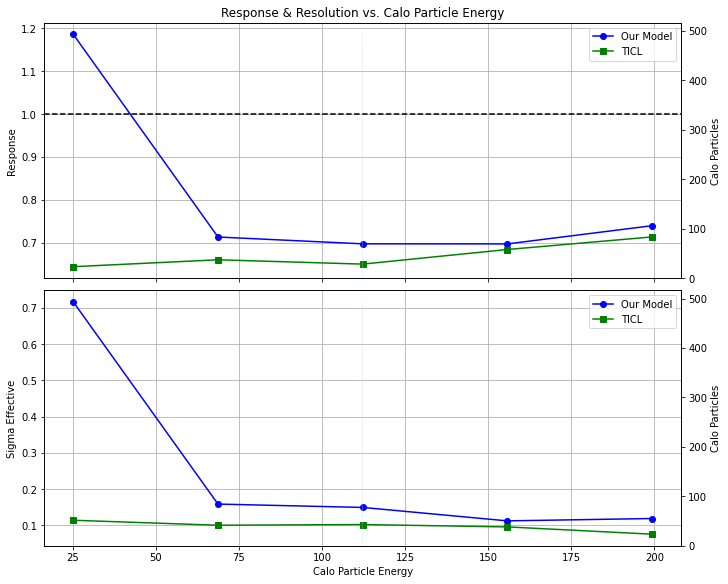

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# 1. Preprocessing and Association Selection for Calo Particles
# ====================================================
def process_cp_dataframe(df):
    df = df.copy()
    for col in ['cp_id', 'sim_to_reco_score', 'reco_to_sim_score', 'cp_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_cp = df[df['sim_to_reco_score'] < 0.2]
    #df_cp = df_cp[(df_cp['energy_ratio'] >= 0) & (df_cp['energy_ratio'] <= 2)]
    df_cp = df_cp.loc[df_cp.groupby(['event_index', 'cp_id'])['sim_to_reco_score'].idxmin()].reset_index(drop=True)
    return df_cp

df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# ====================================================
# 2. Binning by Calo Particle Energy (cp_energy)
# ====================================================
n_bins = 5
energy_bins = np.histogram_bin_edges(df_CL_cp['cp_energy'], bins=n_bins)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

df_CL_cp['energy_bin'] = np.digitize(df_CL_cp['cp_energy'], bins=energy_bins) - 1
df_TICL_cp['energy_bin'] = np.digitize(df_TICL_cp['cp_energy'], bins=energy_bins) - 1

# ====================================================
# 3. Compute Sigma Effective in Each Energy Bin
# ====================================================
def compute_sigma_effective(df, n_bins):
    fitted_mean, sigma_eff, counts = [], [], []
    for b in range(n_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        sorted_data = np.sort(bin_data)
        n_points = len(sorted_data)
        if n_points > 0:
            window_size = int(0.683 * n_points)
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2
            sigma_eff_val = (best_range[1] - best_range[0]) / 2
        else:
            mu_eff, sigma_eff_val = np.nan, np.nan
        fitted_mean.append(mu_eff)
        sigma_eff.append(sigma_eff_val)
    return np.array(fitted_mean), np.array(sigma_eff), np.array(counts)

fitted_mean_CL, sigma_eff_CL, counts_CL = compute_sigma_effective(df_CL_cp, n_bins)
fitted_mean_TICL, sigma_eff_TICL, counts_TICL = compute_sigma_effective(df_TICL_cp, n_bins)

# ====================================================
# 4. Plot Histograms with Sigma Effective
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for j, (df, mean, sigma, label, color, ax) in enumerate(zip(
            [df_CL_cp, df_TICL_cp],
            [fitted_mean_CL, fitted_mean_TICL],
            [sigma_eff_CL, sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs])):
        data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        n, bins, _ = ax.hist(data, bins='auto', range=(0, 2), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean[b] - sigma[b], color='r', linestyle='--', label=f'68.3% Range')
        ax.axvline(mean[b] + sigma[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy={bin_centers[b]:.2f}), Count={len(data)}')
        ax.set_xlabel('Energy Ratio')
        ax.set_ylabel('Counts')
        ax.legend()
plt.suptitle('Energy Ratio Histograms with Sigma Effective')
plt.show()

# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
# ====================================================
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

ax_resp.plot(bin_centers, fitted_mean_CL, 'bo-', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, 'gs-', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()
ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=0.1, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Calo Particles')

ax_res.plot(bin_centers, sigma_eff_CL, 'bo-', label='Our Model')
ax_res.plot(bin_centers, sigma_eff_TICL, 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel('Sigma Effective')
ax_res.legend()
ax_res.grid()
ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=0.1, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')
plt.show()


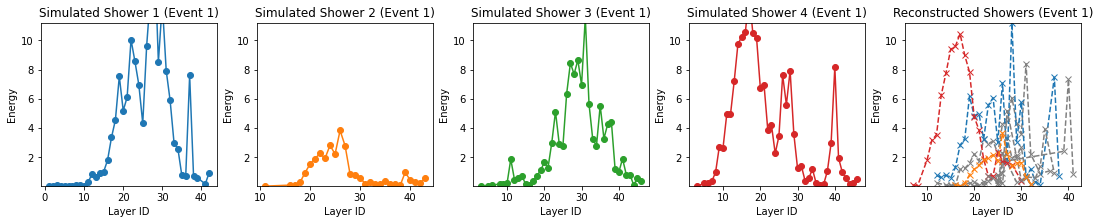

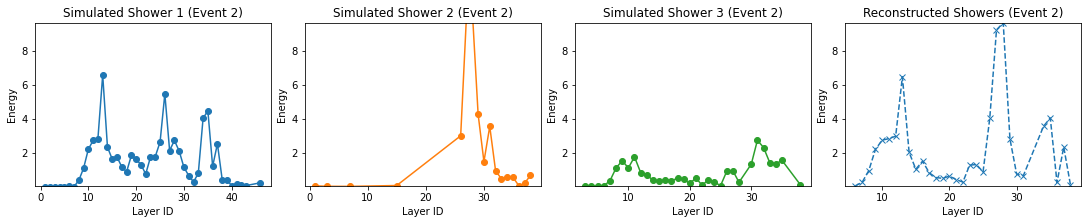

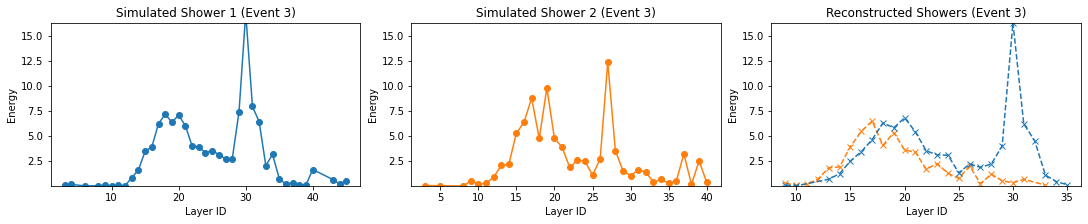

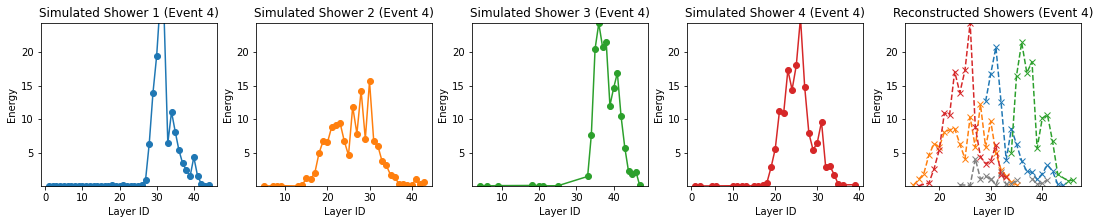

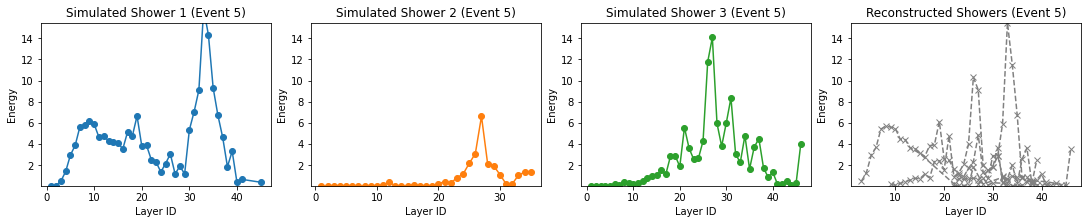

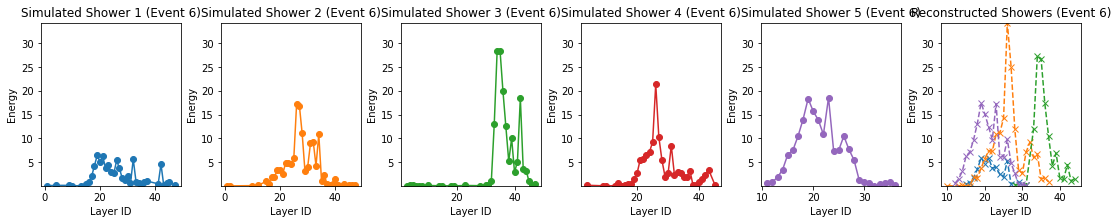

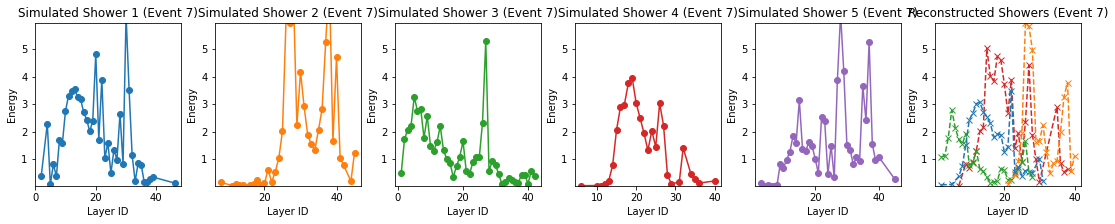

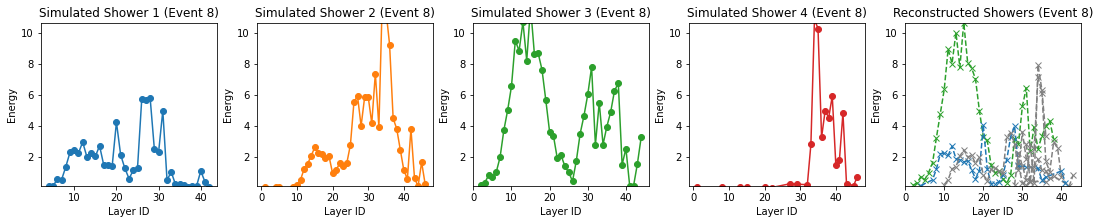

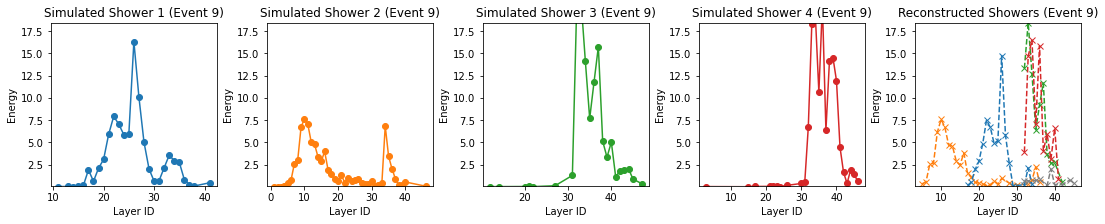

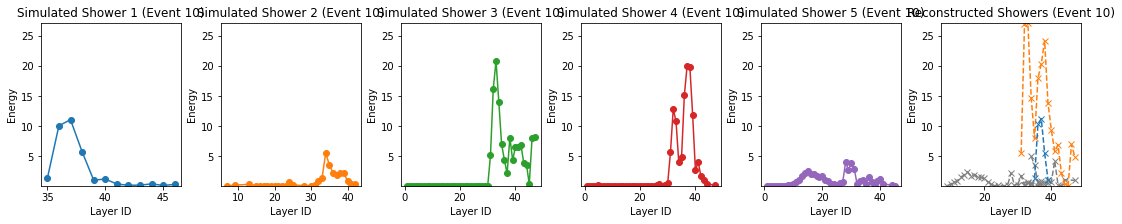

In [41]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters;4']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            # Loop over all Tracksters
            max_shared_energy = 0.0
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                
                
                shared_det_ids = set(calo_det_id for calo_det_id in caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared det_ids

                # Calculate shared_energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx

            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
                    
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events_ours = calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, GT_mult)


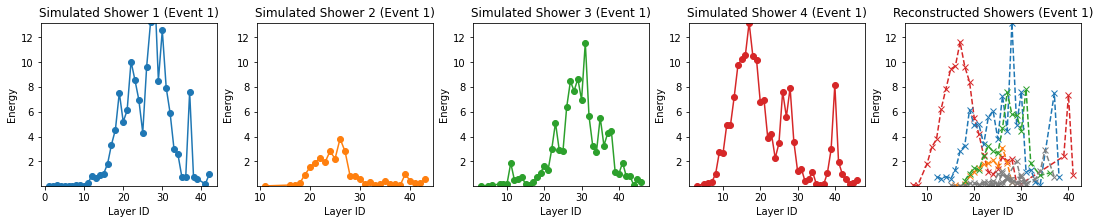

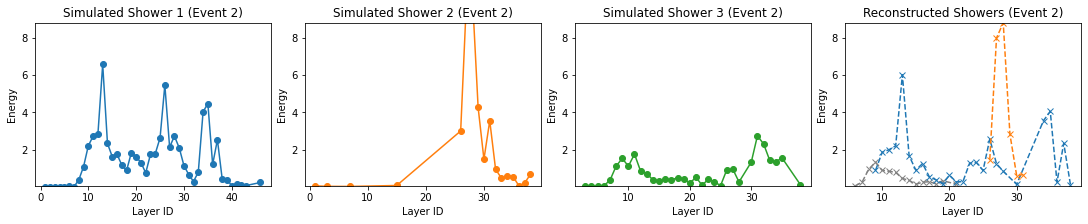

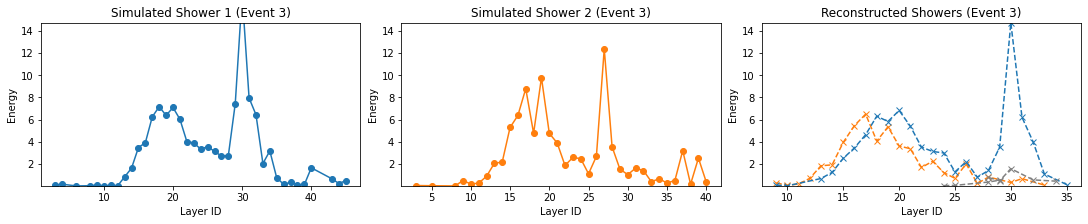

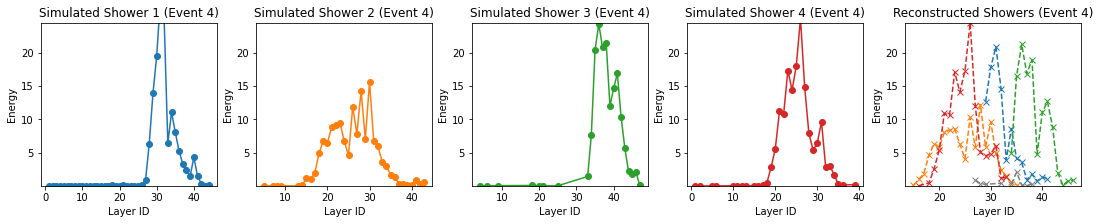

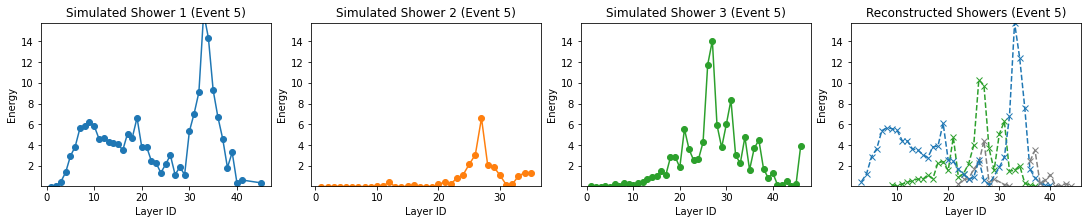

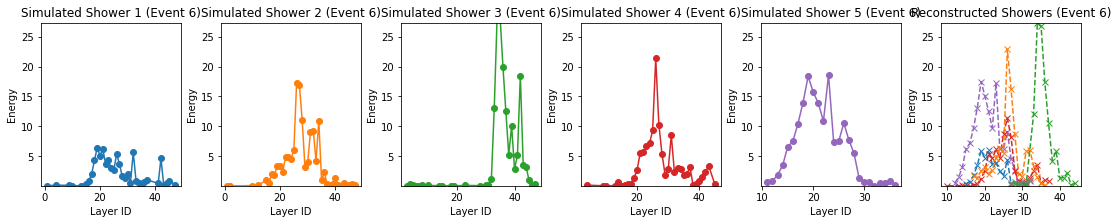

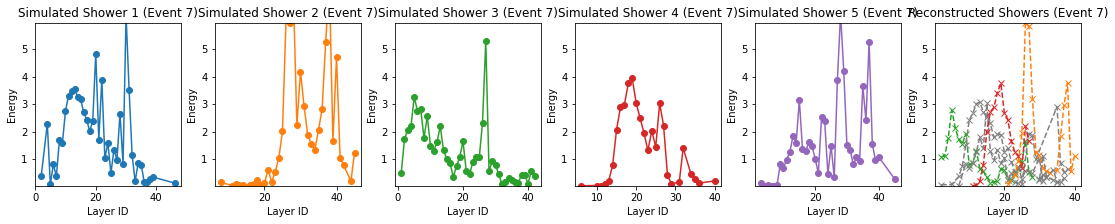

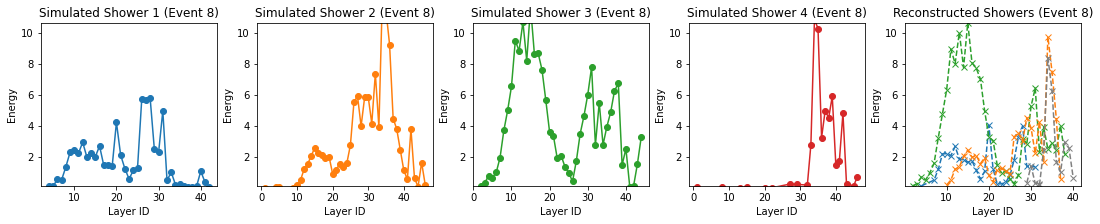

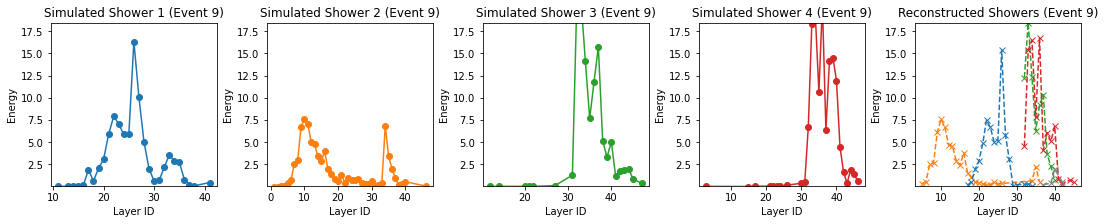

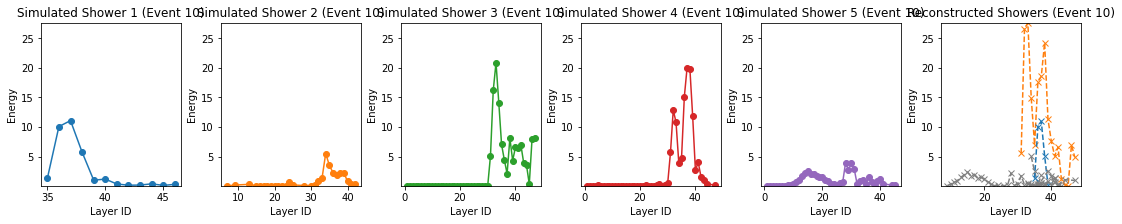

In [42]:
events_TICL = calculate_all_event_profile_data(GT_ind, energies, MT_ind_filt, layer, GT_mult)